# Environment Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLDL/MLDL1_HW4'

/content/drive/MyDrive/MLDL/MLDL1_HW4


In [4]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0
!pip install torchtext==0.16.0
!pip install portalocker>=2.0.0 # 해당 셀 실행 이후 '런타임 > 런타임 다시 시작' 후 위에서부터 다시 실행

In [5]:
%load_ext tensorboard

In [6]:
import time
import math
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

In [7]:
"""
import modules you need
"""


'\nimport modules you need\n'

In [8]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 2.1.0+cu121, Device: cuda
Using torchtext version: 0.16.0+cpu


# Load Data

In [9]:
"""
Load AG_NEWS dataset and set up the tokenizer and encoder pipeline.

Do NOT modify.
"""

train_data, test_data = torchtext.datasets.AG_NEWS(root='./data')

tokenizer = get_tokenizer('basic_english')

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

encoder = build_vocab_from_iterator(tokens(train_data), specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])

text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [10]:
def collate_batch(
    batch: List[Tuple[int, str]]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Creates a batch of encoded text, label and token length tensors.

    Question (a)
    - The input texts in the batch have different lengths.
    - Complete your code to make them have same length using their average.
    - This means that the length of token sequence in each batch is determined by
      the average of token length of all sequences in each batch.
    - Text tensors are stacked with dimension of (TOKEN_LENGTH, BATCH),
      for easier process in RNN model.
    - Token length tensors are used to index the last valid hidden token for classification.

    Args:
      batch: list of tuples, each containing an integer label and a text input.
      - ex) [(3, "Wall St. Bears..."), (4, "Comtes, Asteroids and ..."), ...]
      - number of tuples in the list is same as BATCH SIZE.

    Returns:
      text_list: batch of encoded long type text tensors with size (TOKEN_LENGTH, BATCH)
      label_list: batch of label tensors with size (BATCH)
      len_list: batch of token length tensors with size (BATCH)
    """

    text_list, label_list, len_list = [], [], []

    # Tokenize and encode each text in the batch using the text_pipeline
    tokenized_texts = [text_pipeline(text) for _, text in batch]
    lengths = [len(tokens) for tokens in tokenized_texts]

    # Calculate the average length of tokenized sequences
    avg_length = int(sum(lengths) / len(lengths))

    # Pad or truncate each tokenized sequence to the average length
    padded_texts = []
    for tokens in tokenized_texts:
        if len(tokens) > avg_length:
            padded_texts.append(tokens[:avg_length])
        else:
            padded_texts.append(tokens + [encoder["<pad>"]] * (avg_length - len(tokens)))

    # Create tensors
    text_list = torch.tensor(padded_texts, dtype=torch.long).transpose(0, 1)  # Shape: (TOKEN_LENGTH, BATCH)
    label_list = torch.tensor([label_pipeline(label) for label, _ in batch], dtype=torch.long)  # Shape: (BATCH)
    len_list = torch.tensor(lengths, dtype=torch.long)  # Shape: (BATCH)

    assert text_list.size(1) == len(batch)

    return (text_list, label_list, len_list)

In [11]:
"""
Load the data loader.

Do NOT modify.
"""

BATCH_SIZE = 512

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

In [12]:
"""
Print out the first batch in the train loader.
Check if the collate function is implemented correctly.

Do NOT modify.
"""

batch_x, batch_y, len_x = next(iter(train_dataloader))
print(batch_x[:10])
print(batch_y[:10])
print(len_x[:10])

tensor([[60593,   272,    69,  ..., 11231,   330,  3452],
        [    1,  4902,    71,  ...,  7232,  3723,    84],
        [  172,    43,    21,  ...,  4246,  4996,  5046],
        ...,
        [11695,    13,   303,  ...,  4043,   216,  4143],
        [ 5249,    27,     2,  ...,    12,   581,  1919],
        [ 1129,    14,   584,  ...,     9,    13,     7]])
tensor([1, 2, 1, 2, 1, 3, 3, 3, 3, 2])
tensor([38, 52, 40, 33, 57, 70, 65, 31, 51, 42])


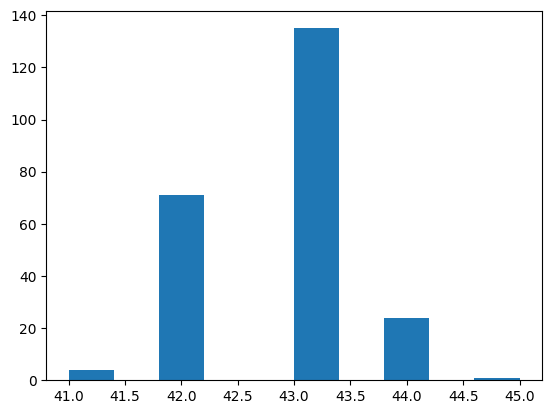

In [13]:
"""
Plot the sequence length distribution of the batches in the train dataloader.
Make sure that all batches have difference sequence lengths.

Do NOT modify.
"""

batch_len = []
for batch_x, _, _ in train_dataloader:
    seq_len = batch_x.size(0)
    batch_len.append(seq_len)
plt.hist(batch_len)
plt.show()

# Model

In [14]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        input_size: int,
        hidden_size: int,
        num_class: int,
        dropout_ratio: float,
    ):
        """
        Define the model weight parameters and initialize the weights.

        Question (b)
        - Complete the dimension and shape of the weights and biases.
        - Use the model parameters (vocab_size, input_size, hidden_size, num_class).

        Args:
          vocab_size: size of dictionary of vocabularies.
          input_size: size of each embedding vector.
          hidden_size: size of hidden dimension.
          num_class: size of output classes.
          dropout_ratio: probability of an element to be zeroed.
        """
        super(RNN, self).__init__()

        ##### YOUR CODE #####
        whh_size = (hidden_size, hidden_size)
        wxh_size = (input_size, hidden_size)
        why_size = (hidden_size, num_class)
        bhh_size = (hidden_size,)
        bxh_size = (hidden_size,)
        bhy_size = (num_class,)
        #####################

        kwargs = {'device': DEVICE, 'dtype': torch.float}
        self.dropout = dropout_ratio
        self.hidden = hidden_size
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.W_hh = nn.parameter.Parameter(torch.empty(whh_size, **kwargs))
        self.W_xh = nn.parameter.Parameter(torch.empty(wxh_size, **kwargs))
        self.W_hy = nn.parameter.Parameter(torch.empty(why_size, **kwargs))
        self.b_hh = nn.parameter.Parameter(torch.empty(bhh_size, **kwargs))
        self.b_xh = nn.parameter.Parameter(torch.empty(bxh_size, **kwargs))
        self.b_hy = nn.parameter.Parameter(torch.empty(bhy_size, **kwargs))

        self.init_parameters()

    def init_parameters(self):
        """
        Initialize the parameters with Kaiming uniform initialization.

        Do NOT modify this method.
        """
        nn.init.kaiming_uniform_(self.W_hh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_xh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_xh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_xh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hy)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hy, -bound, bound)

    def forward(self, inputs: torch.Tensor, length: torch.Tensor) -> torch.Tensor:
        """
        Question (c)
        - Randomly initialize h_0 with appropriate shape.
        - Pass a sequence of tokens into the recurrent network.
        - Implement dropout to embedded tokens with the given probability (self.dropout).
          For example, if self.dropout is 0.3, 30% of the embedded tokens will be dropped out.
        - We do not want to use a hidden cell of a zero-padded token for classification!
        - Index the hidden cell of the last valid token (excluding the zero-padding)
          based on the token length of each example in the batch.
        - Do NOT use pre-defined PyTorch layers for this question. (e.g. nn.RNN, nn.Dropout)

        Args:
          inputs: a batch of encoded token sequences with shape (SEQ_LEN, BATCH_SIZE)
          length: a batch of token lengths with shape (BATCH_SIZE)

        Returns:
          Softmax probabilites for each class with shape (BATCH_SIZE, NUM_CLASS)
        """

        embedded = self.embedding(inputs)  # Shape: (SEQ_LEN, BATCH_SIZE)

        # Apply dropout to embeddings
        if self.training:
            mask = torch.rand(embedded.size(), device=inputs.device) > self.dropout
            embedded = embedded * mask.float()

        # Initialize hidden state
        batch_size = inputs.size(1)
        h_t = torch.randn(batch_size, self.hidden, device=inputs.device)

        # Process the sequence through the RNN manually
        for t in range(embedded.size(0)):
            h_t = torch.tanh(
                torch.matmul(embedded[t], self.W_xh) + self.b_xh +
                torch.matmul(h_t, self.W_hh) + self.b_hh
            )

        # Collect the hidden states at the last valid token index for each example
        last_hidden_states = h_t

        # Output layer
        logits = torch.matmul(last_hidden_states, self.W_hy) + self.b_hy  # Shape: (BATCH_SIZE, NUM_CLASS)
        softmax_probs = F.log_softmax(logits, dim=1)

        return softmax_probs

    def compute_loss(
        self,
        prediction: torch.Tensor,
        label: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """
        Question (d)

        - Compute the cross entropy loss and the number of correct predictions
        - Do NOT use loss function in torch.nn library (e.g. nn.CrossEntropyLoss())

        Args:
          prediction: output(softmax probabilities) from self.forward function with shape (BATCH_SIZE, NUM_CLASS)
          label: integer labels of the batch inputs with shape (BATCH_SIZE)

        Returns:
          cross entropy loss of the batch (float tensor) and the number of correct predictions (integer)
        """

        batch_size = prediction.size(0)

        # Compute cross entropy loss
        predictions = torch.log_softmax(prediction, dim=1)
        loss = -predictions[torch.arange(batch_size), label].mean()

        # Compute number of correct predictions
        _, predicted_labels = torch.max(prediction, 1)
        correct = (predicted_labels == label).sum().item()

        return (loss, correct)

# Training Modules

In [15]:
class ScheduledOptim():
    """
    Learning rate scheduler.

    Do NOT modify.
    """

    def __init__(self, optimizer, n_warmup_steps, decay_rate):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()

    def step(self):
        self._optimizer.step()

    def get_lr(self):
        return self.current_lr

    def update(self):
        if self.n_steps < self.n_warmup_steps:
            lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
            lr = self.initial_lr
        else:
            lr = self.current_lr * self.decay

        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

        self.n_steps += 1

# Model Training

In [16]:
"""
Functions for training and evaluating the model.

Question (e)
- Compared to practice 3 (RNN Text Classification) covered in the lab session 3, there has been minor
  modification with scheduler and loss computation. Check what should have been changed, and complete
  the train and evaluate function that works for the current training pipeline
- Use the methods of the ScheduledOptim class above to perform necessary operations on the optimizer.
- Do NOT change the arguments given to the train, evaluate functions.
"""

def train(model, train_loader, scheduler):

    model.train()
    train_loss = 0
    correct = 0

    tqdm_bar = tqdm(train_loader)

    for text, label, length in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        length = length.to(DEVICE)

        # Forward pass
        output = model(text, length)

        # Compute loss and correct predictions
        loss, correct_preds = model.compute_loss(output, label)

        # Backward pass and optimization
        scheduler.zero_grad()
        loss.backward()
        scheduler.step()

        # Accumulate loss and correct predictions
        train_loss += loss.item() * text.size(1)
        correct += correct_preds

        # Update the progress bar
        tqdm_bar.set_description(f"Train Loss: {loss.item():.4f}, Acc: {correct_preds / text.size(1):.4f}")

    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)

    return train_loss, train_acc


def evaluate(model, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    tqdm_bar = tqdm(test_loader)

    with torch.no_grad():
        for text, label, length in tqdm_bar:
            text = text.to(DEVICE)
            label = label.to(DEVICE)
            length = length.to(DEVICE)

            # Forward pass
            output = model(text, length)

            # Compute loss and correct predictions
            loss, correct_preds = model.compute_loss(output, label)

            # Accumulate loss and correct predictions
            test_loss += loss.item() * text.size(1)
            correct += correct_preds

            # Update the progress bar
            tqdm_bar.set_description(f"Test Loss: {loss.item():.4f}, Acc: {correct_preds / text.size(1):.4f}")

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    return test_loss, test_acc

In [ ]:
"""
Question (f)
- Train your RNN model and obtain the test accuracy of 70%.
- Select the input size, hidden size of your choice
- Try various optimizer type, learning rate and scheduler options for the best performance.
- Visualize your experiments with Tensorboard.
- Your TensorBoard results should include Train/Validation Loss and Accuracy.
"""

##### YOUR CODE #####
writer = SummaryWriter(log_dir="./logs")

EPOCHS = 60
BATCH_SIZE = 64
vocab_size = len(encoder)
input_size = 128
hidden_size = 256
num_class = 4  # AG_NEWS has 4 classes
dropout_ratio = 0.5
learning_rate = 0.001

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

# Model Initialization
model = RNN(vocab_size, input_size, hidden_size, num_class, dropout_ratio).to(DEVICE)

# Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ScheduledOptim(optimizer, n_warmup_steps=100, decay_rate=0.5)

for epoch in range(1, EPOCHS + 1):
    loss_train, accu_train = train(model, train_dataloader, scheduler)
    loss_val, accu_val = evaluate(model, valid_dataloader)
    lr = scheduler.get_lr()

    # Logging to TensorBoard
    writer.add_scalar('Loss/Train', loss_train, epoch)
    writer.add_scalar('Loss/Validation', loss_val, epoch)
    writer.add_scalar('Accuracy/Train', accu_train, epoch)
    writer.add_scalar('Accuracy/Validation', accu_val, epoch)
    writer.add_scalar('Learning Rate', lr, epoch)

    print('-' * 83)
    print('| end of epoch {:2d} | lr: {:5.4f} | train loss: {:8.3f} | train accuracy: {:8.3f} | '
          'valid accuracy {:8.3f} '.format(epoch, lr, loss_train, accu_train, accu_val))
    print('-' * 83)

writer.flush()
writer.close()
#####################

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  1 | lr: 0.0010 | train loss:    1.323 | train accuracy:   39.063 | valid accuracy   28.803 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  2 | lr: 0.0010 | train loss:    1.316 | train accuracy:   33.292 | valid accuracy   32.342 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  3 | lr: 0.0010 | train loss:    1.231 | train accuracy:   38.002 | valid accuracy   51.421 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  4 | lr: 0.0010 | train loss:    1.034 | train accuracy:   48.435 | valid accuracy   54.461 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  5 | lr: 0.0010 | train loss:    1.016 | train accuracy:   49.787 | valid accuracy   54.066 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  6 | lr: 0.0010 | train loss:    0.938 | train accuracy:   53.157 | valid accuracy   52.382 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  7 | lr: 0.0010 | train loss:    0.898 | train accuracy:   55.149 | valid accuracy   58.066 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  8 | lr: 0.0010 | train loss:    0.865 | train accuracy:   58.166 | valid accuracy   56.408 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  9 | lr: 0.0010 | train loss:    0.856 | train accuracy:   58.283 | valid accuracy   58.421 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 10 | lr: 0.0010 | train loss:    0.857 | train accuracy:   59.374 | valid accuracy   59.974 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 11 | lr: 0.0010 | train loss:    0.823 | train accuracy:   60.536 | valid accuracy   61.211 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 12 | lr: 0.0010 | train loss:    0.715 | train accuracy:   66.222 | valid accuracy   64.750 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 13 | lr: 0.0010 | train loss:    0.693 | train accuracy:   67.904 | valid accuracy   63.447 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 14 | lr: 0.0010 | train loss:    0.775 | train accuracy:   63.171 | valid accuracy   60.579 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 15 | lr: 0.0010 | train loss:    0.856 | train accuracy:   59.968 | valid accuracy   58.079 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 16 | lr: 0.0010 | train loss:    0.775 | train accuracy:   64.176 | valid accuracy   62.474 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 17 | lr: 0.0010 | train loss:    0.765 | train accuracy:   64.000 | valid accuracy   60.855 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 18 | lr: 0.0010 | train loss:    0.889 | train accuracy:   57.636 | valid accuracy   64.342 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 19 | lr: 0.0010 | train loss:    0.748 | train accuracy:   66.456 | valid accuracy   60.158 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 20 | lr: 0.0010 | train loss:    0.711 | train accuracy:   68.353 | valid accuracy   62.421 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 21 | lr: 0.0010 | train loss:    1.137 | train accuracy:   46.101 | valid accuracy   52.697 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 22 | lr: 0.0010 | train loss:    0.892 | train accuracy:   56.127 | valid accuracy   58.447 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 23 | lr: 0.0010 | train loss:    0.833 | train accuracy:   60.010 | valid accuracy   60.737 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 24 | lr: 0.0010 | train loss:    0.846 | train accuracy:   60.225 | valid accuracy   57.289 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 25 | lr: 0.0010 | train loss:    0.877 | train accuracy:   59.392 | valid accuracy   47.224 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 26 | lr: 0.0010 | train loss:    1.218 | train accuracy:   41.992 | valid accuracy   46.500 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 27 | lr: 0.0010 | train loss:    1.231 | train accuracy:   41.935 | valid accuracy   46.684 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 28 | lr: 0.0010 | train loss:    1.219 | train accuracy:   42.718 | valid accuracy   48.934 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 29 | lr: 0.0010 | train loss:    1.128 | train accuracy:   47.392 | valid accuracy   54.368 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 30 | lr: 0.0010 | train loss:    0.988 | train accuracy:   52.917 | valid accuracy   55.447 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 31 | lr: 0.0010 | train loss:    1.068 | train accuracy:   49.091 | valid accuracy   45.039 
-----------------------------------------------------------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
# (f) Visualize the experimental logs with TensorBoard
# Submission of the visualization result is not required.
%tensorboard --logdir ./logs